## Setup, Loading Data and CDFs

In [4]:
DATA_NAME = 'coco-indoor' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = 'blue'

In [5]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
blue_diagonal_wavelet_indoor_coco.ipynb


In [6]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\results\\case-studies\\coco\\indoor\\wavelet\\diagonal\\blue'

In [7]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [8]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [9]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 1604,
 3: 6416,
 4: 25664,
 5: 102656,
 6: 410624,
 7: 1642496,
 8: 6569984,
 9: 26279936}

Running 12760 CDFs


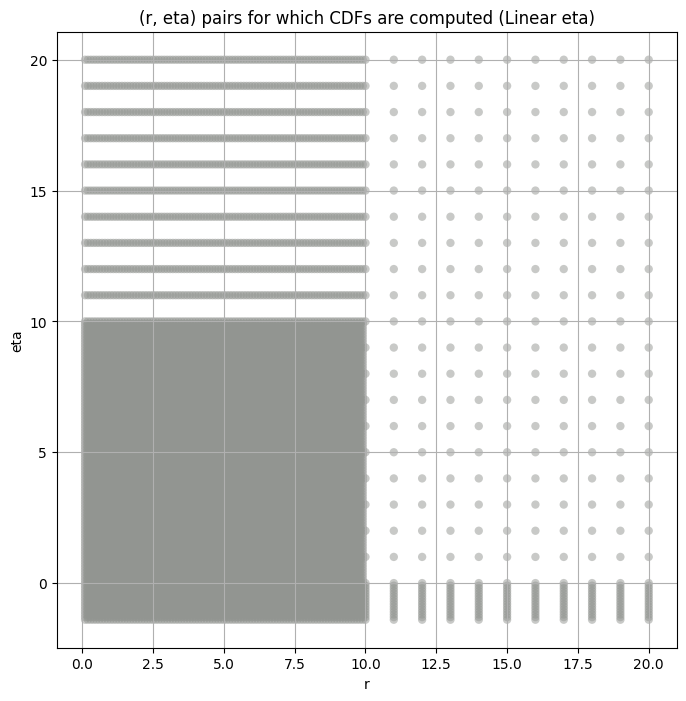

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [10]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [11]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [12]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
layer,,,,,,,
2,1538.617600,1361.700400,1726.071300,1.384708,0.755833,2.144949,1604.0
3,319.928740,298.205600,342.533800,2.654936,2.018415,3.406429,6416.0
4,61.059418,57.133404,65.097885,4.362754,3.728140,5.085071,25664.0
5,10.662790,9.844688,11.527634,7.503035,6.107224,9.759243,102656.0
6,1.812355,1.650693,1.984610,10.935183,8.771862,14.155710,410624.0
7,0.367574,0.331668,0.407110,13.701681,10.461758,19.611970,1642496.0
8,0.117648,0.106599,0.130179,12.731473,8.530438,23.293043,6569984.0
9,0.061505,0.056850,0.066728,7.600587,4.638381,15.639812,26279936.0


## Initial Grid Search and Hypothesis Test Plots

In [13]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [14]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
layer,,,,,,,,,,,,
2,1538.617600,1538.617554,1161.098145,963.112366,819.260986,703.276917,526.678162,398.401367,302.134521,228.365967,172.957947,62.058540
3,319.928740,319.928741,280.625305,258.035675,240.640320,225.790222,201.310745,181.514954,164.611450,149.865097,136.984894,105.917030
4,61.059418,61.059418,57.894295,55.703251,53.823540,52.122368,49.203133,46.678894,44.464397,42.499531,40.742306,36.268787
5,10.662790,10.662790,10.376114,10.178217,10.008466,9.859303,9.595421,9.361814,9.148827,8.951756,8.767480,8.274236
6,1.812355,1.812355,1.750605,1.708828,1.673743,1.642425,1.587271,1.538528,1.494740,1.454626,1.417591,1.319823
7,0.367574,0.367574,0.352329,0.342404,0.334114,0.326777,0.314018,0.302986,0.293188,0.284348,0.276250,0.255318
8,0.117648,0.117648,0.112412,0.109279,0.106714,0.104481,0.100650,0.097398,0.094547,0.092003,0.089699,0.083852
9,0.061505,0.061505,0.059298,0.058013,0.056976,0.056091,0.054608,0.053379,0.052319,0.051384,0.050542,0.048392


####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.012809633231170459 1538.6176


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.027200597223772216 1161.0981


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.04207861592080964 963.11237


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.0575696270777355 819.261


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.0729707694328009 703.2769


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.10075394050161524 526.67816


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.12310942279241766 398.40137


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.1490506452371364 302.13452


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.17519770808728596 228.36597


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.203010163236091 172.95795


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.2846595549055905 62.05854
Number of samples: 1604, Without approximation : 1604.0


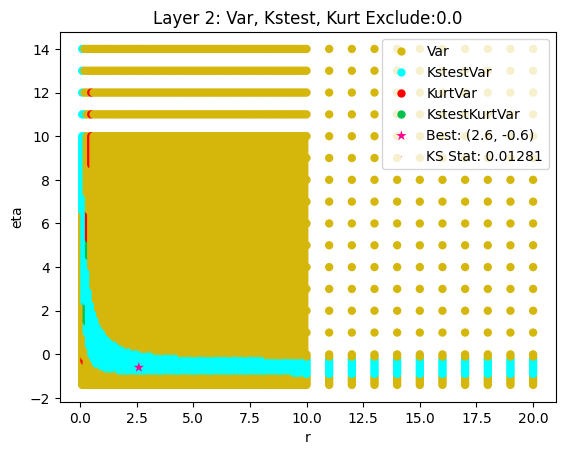

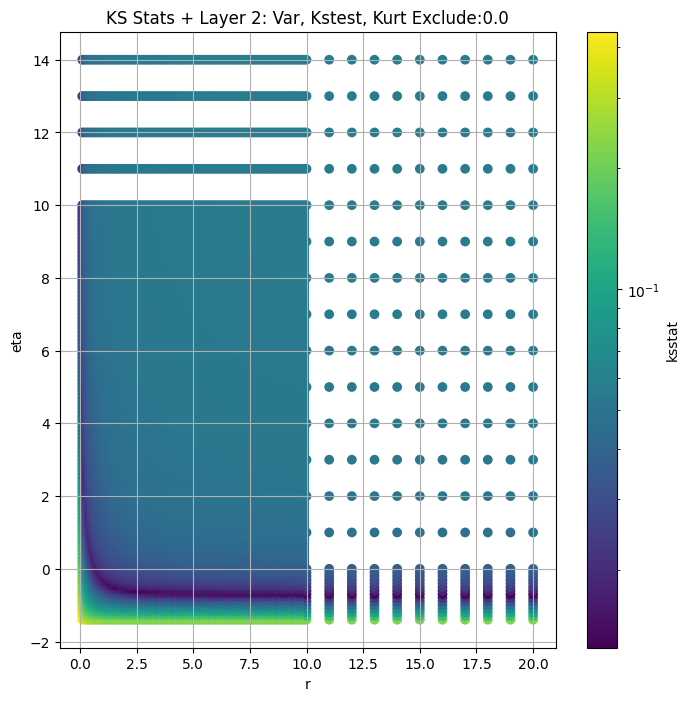

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.01283030797073148 319.92874


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.015469507814583283 280.6253


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.0186679951343251 258.03568


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.022124621702115155 240.64032


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.0260607476662702 225.79022


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.034190938177268815 201.31075


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.04164157673822111 181.51495


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.04893778755933306 164.61145


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.05591845187066857 149.8651


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.06292169340612878 136.9849


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.08452026204059365 105.91703
Number of samples: 6416, Without approximation : 6416.0


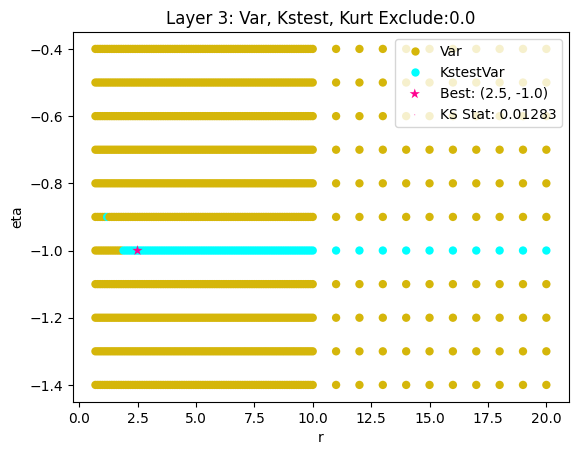

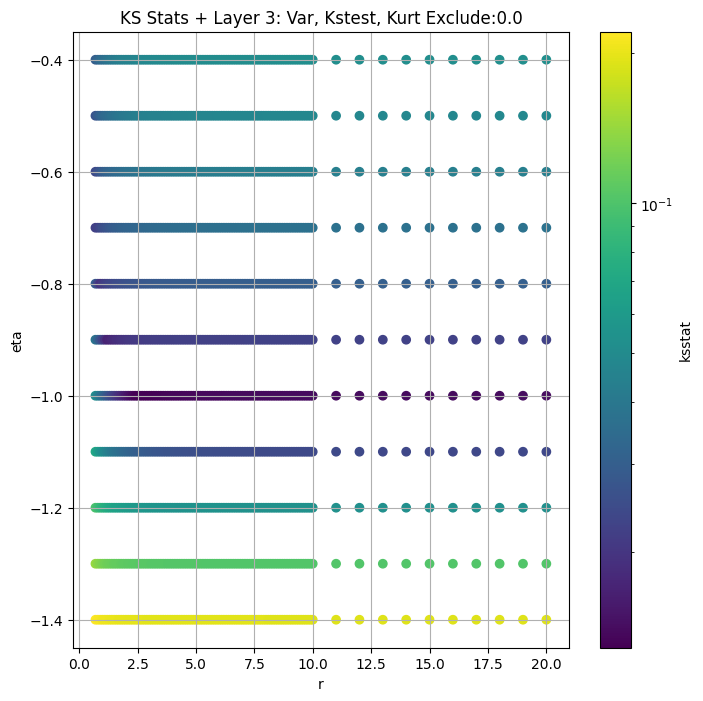

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.028516464198407587 61.059418


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.028498461177183576 57.894295


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.028485110991369633 55.70325


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.028473014893416804 53.82354


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.028461509150619957 52.122368


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.028440394012540837 49.203133


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.028437231809218533 46.678894


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.028437254627902586 44.464397


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.02843725101701855 42.49953


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.03019026326757568 40.742306


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.03082968354767668 36.268787
Number of samples: 25664, Without approximation : 25664.0


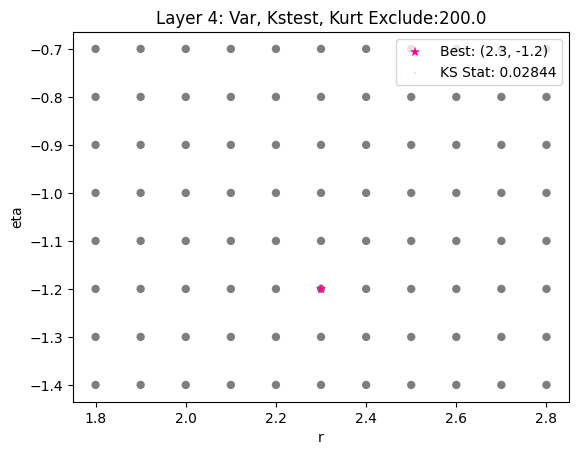

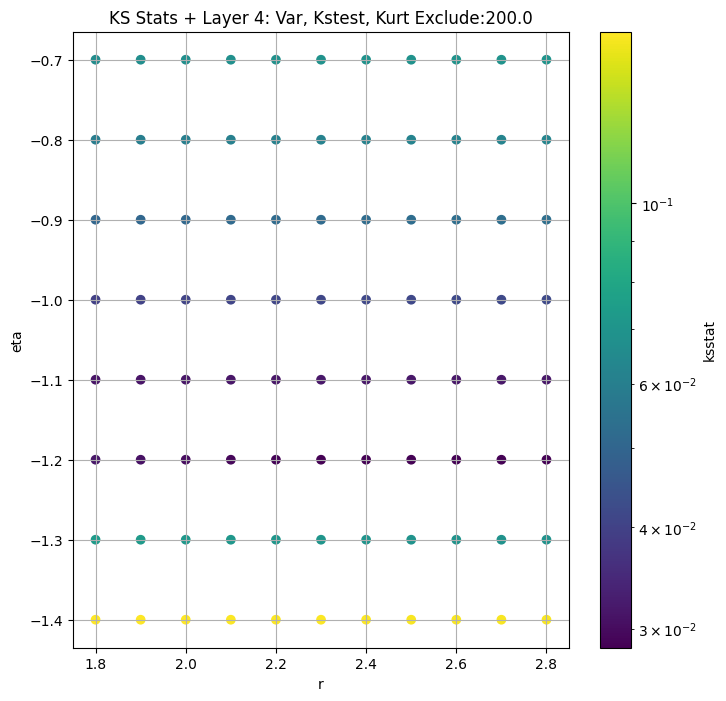

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.06243999999999983 10.66279


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.06243999999999983 10.376114


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.06243999999999983 10.178217


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.06243999999999983 10.008466


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.06243999999999983 9.859303


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.06243999999999983 9.595421


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.06243999999999983 9.3618145


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.06243999999999983 9.148827


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.06243999999999983 8.9517565


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.06243999999999983 8.76748


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.06243999999999983 8.274236
Number of samples: 100000, Without approximation : 102656.0


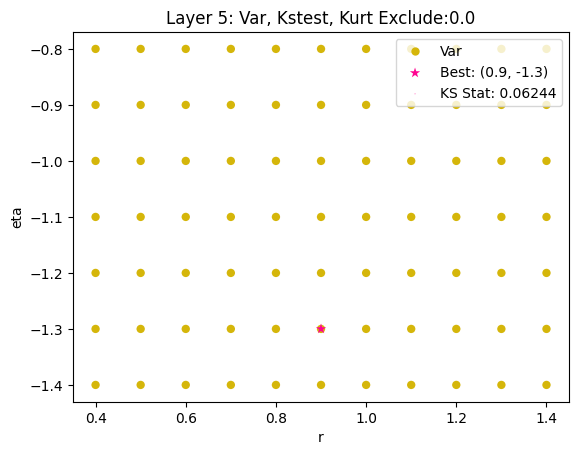

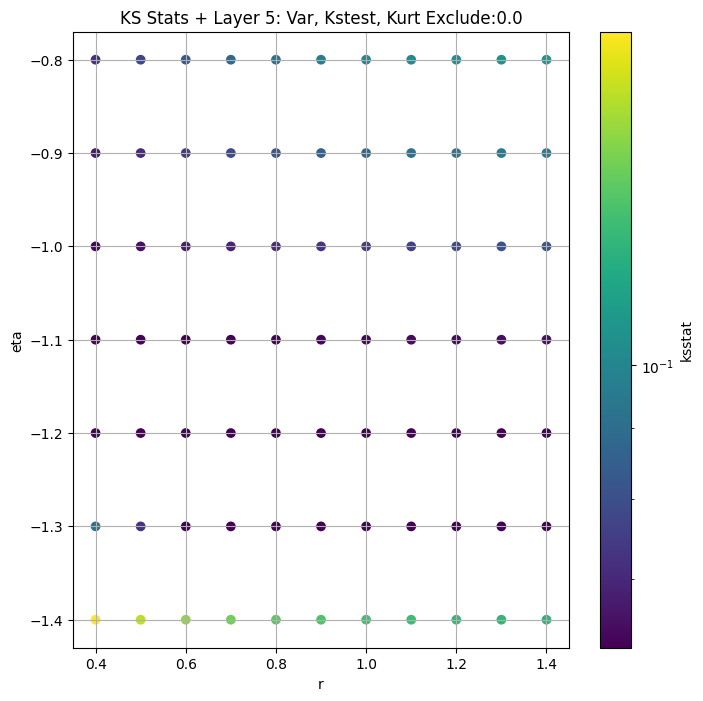

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.10255999999999976 1.812355


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.10255999999999976 1.7506055


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.10255999999999976 1.7088282


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.10255999999999976 1.6737435


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.10255999999999976 1.6424254


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.10255999999999976 1.5872713


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.10255999999999976 1.5385284


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.10255999999999976 1.4947402


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.10255999999999976 1.4546263


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.10255999999999976 1.4175912


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.10255999999999976 1.3198234
Number of samples: 100000, Without approximation : 410624.0


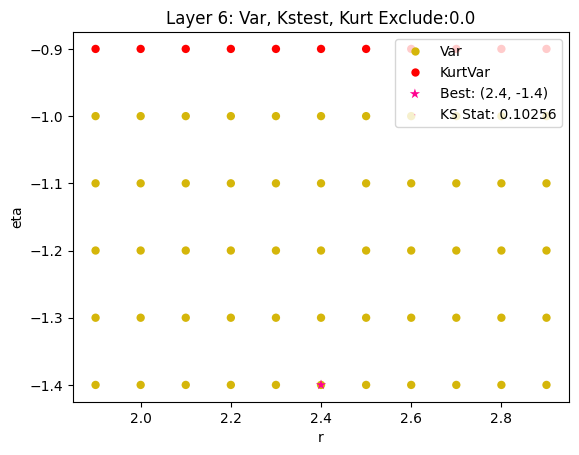

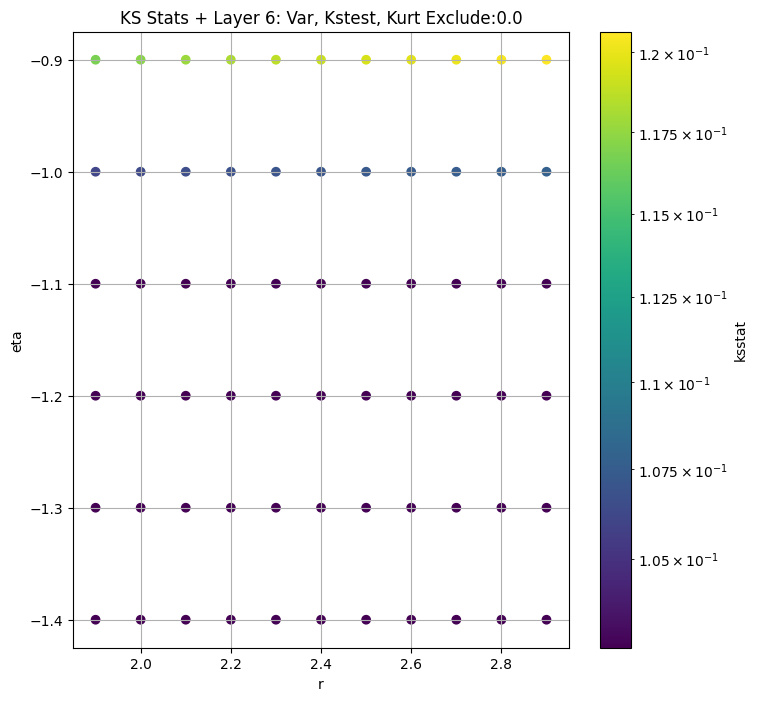

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.14156999999999975 0.36757448


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.14156999999999975 0.35232902


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.14156999999999975 0.34240374


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.14156999999999975 0.33411375


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.14156999999999975 0.32677665


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.14156999999999975 0.314018


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.14156999999999975 0.30298588


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.14156999999999975 0.29318848


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.14156999999999975 0.2843482


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.14156999999999975 0.27625036


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.14156999999999975 0.25531757
Number of samples: 100000, Without approximation : 1642496.0


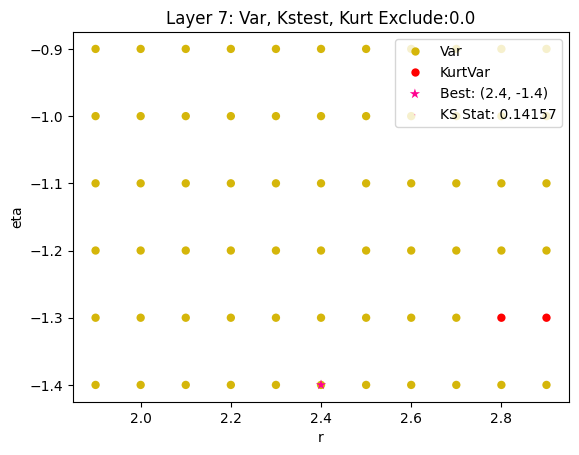

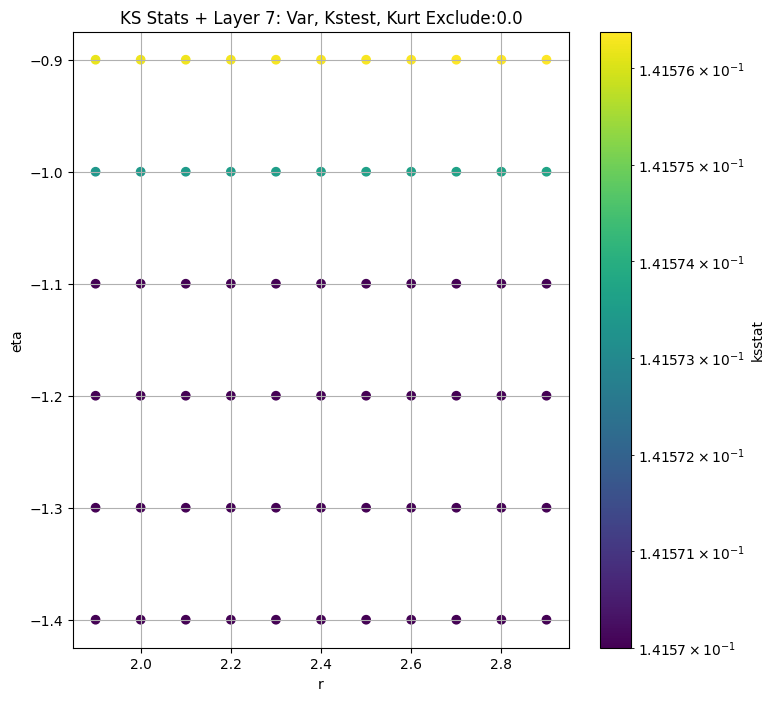

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.17545999999999978 0.117648005


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.17545999999999978 0.11241156


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.17545999999999978 0.10927905


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.17545999999999978 0.1067138


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.17545999999999978 0.10448108


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.17545999999999978 0.10065024


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.17545999999999978 0.09739831


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.17545999999999978 0.09454713


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.17545999999999978 0.09200254


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.17545999999999978 0.08969946


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.17545999999999978 0.08385186
Number of samples: 100000, Without approximation : 6569984.0


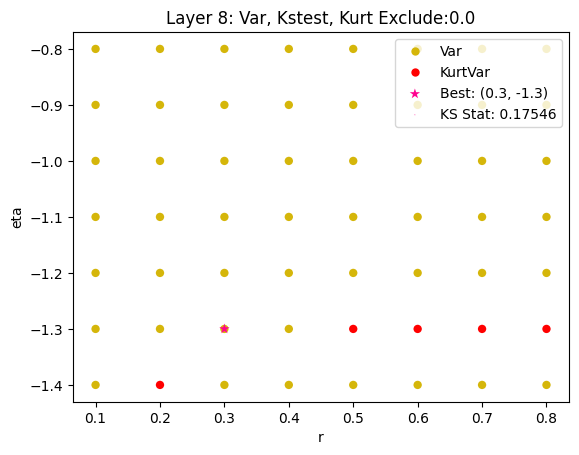

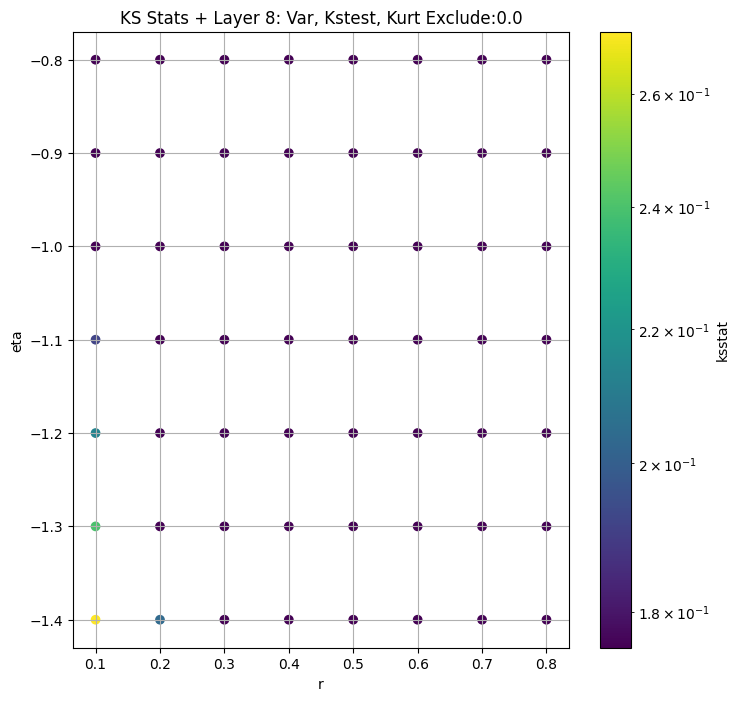

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.20820999999999978 0.06150524


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.20820999999999978 0.059297685


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.20820999999999978 0.05801308


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.20820999999999978 0.056976486


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.20820999999999978 0.056090992


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.20820999999999978 0.054607883


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.20820999999999978 0.05337852


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.20820999999999978 0.052319467


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.20820999999999978 0.051383957


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.20820999999999978 0.050541934


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.20820999999999978 0.048392333
Number of samples: 100000, Without approximation : 26279936.0


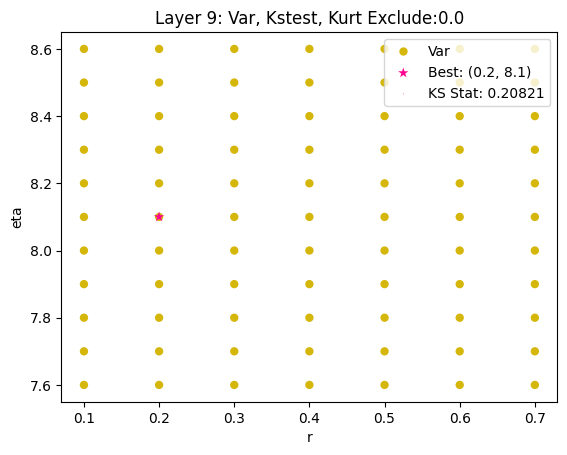

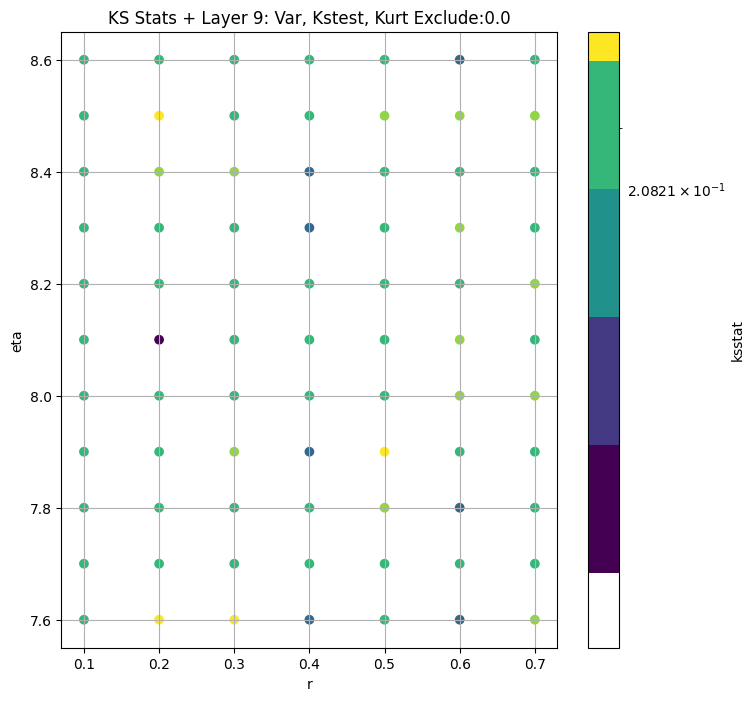

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
layer,,,,,,,,,,,,,,
2,1538.617600,1361.700400,1726.071300,1.384708,0.755833,2.144949,1604.0,0.012810,2.6,-0.6,3.165535e+03,0.0,1538.617600,0.033804
3,319.928740,298.205600,342.533800,2.654936,2.018415,3.406429,6416.0,0.012830,2.5,-1.0,9.862681e+02,0.0,319.928740,0.016929
4,61.059418,57.133404,65.097885,4.362754,3.728140,5.085071,25664.0,0.028437,2.3,-1.2,2.135705e+02,200.0,46.678894,0.008471
5,10.662790,9.844688,11.527634,7.503035,6.107224,9.759243,102656.0,0.062440,0.9,-1.3,4.903539e+01,0.0,10.662790,0.004237
6,1.812355,1.650693,1.984610,10.935183,8.771862,14.155710,410624.0,0.102560,2.4,-1.4,2.200682e+01,0.0,1.812355,0.002119
7,0.367574,0.331668,0.407110,13.701681,10.461758,19.611970,1642496.0,0.141570,2.4,-1.4,4.463334e+00,0.0,0.367574,0.001060
8,0.117648,0.106599,0.130179,12.731473,8.530438,23.293043,6569984.0,0.175460,0.3,-1.3,2.655155e-02,0.0,0.117648,0.000530
9,0.061505,0.056850,0.066728,7.600587,4.638381,15.639812,26279936.0,0.208210,0.2,8.1,1.972111e-10,0.0,0.061505,0.000265


In [15]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [16]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.0779480506544582, var: 703.2769165039062


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.06411575777027834, var: 819.260986328125


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.048727059760290015, var: 963.1123657226562


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.03005823009799391, var: 1161.09814453125


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.012805114356519987, var: 1538.6175537109375
Number of samples: 1604, Without approximation : 1604.0


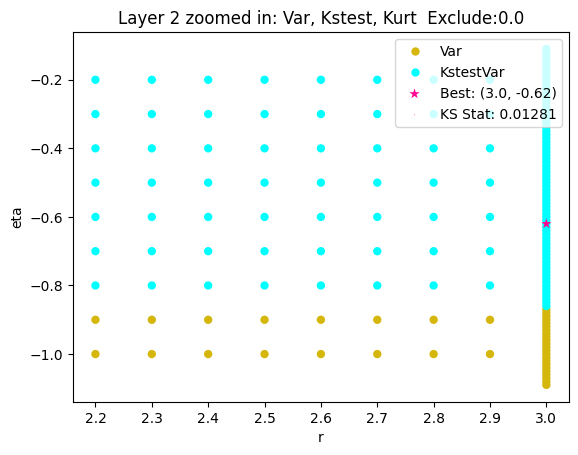

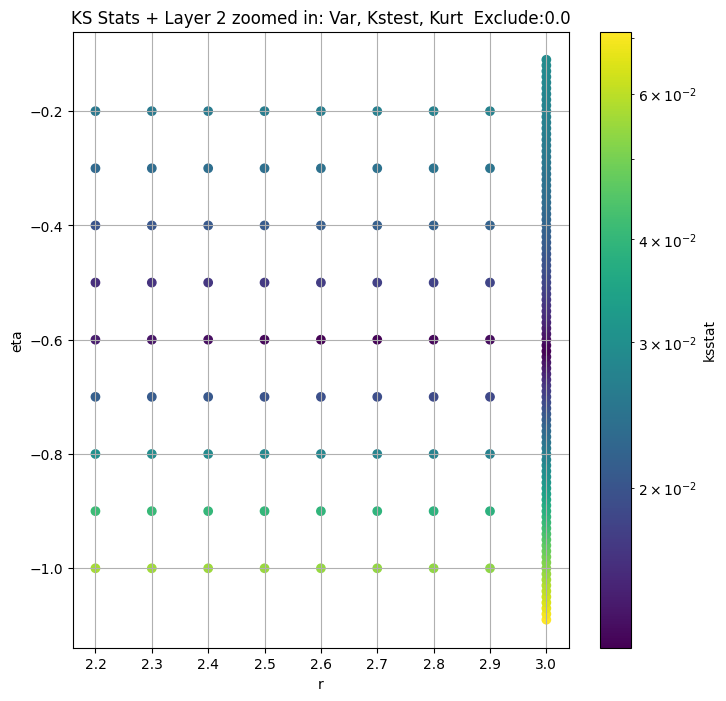

Layer 3


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.027575918352737205, var: 225.79022216796875


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.023517393103503648, var: 240.64031982421875


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.020893118471012218, var: 258.0356750488281


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.018130272886981602, var: 280.62530517578125


  0%|          | 0/81 [00:00<?, ?it/s]

Finding Minimum after computing 81 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.01283030797073148, var: 319.9287414550781
Number of samples: 6416, Without approximation : 6416.0


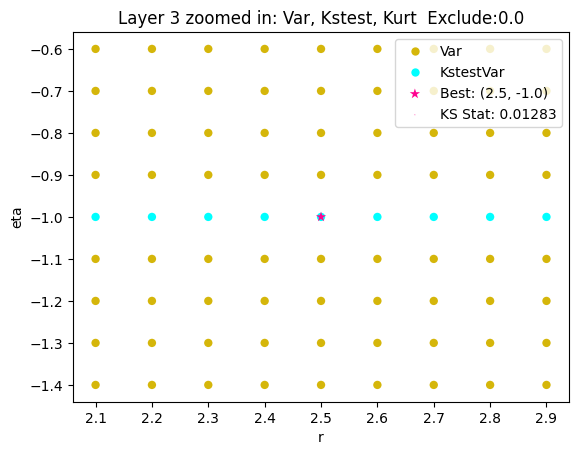

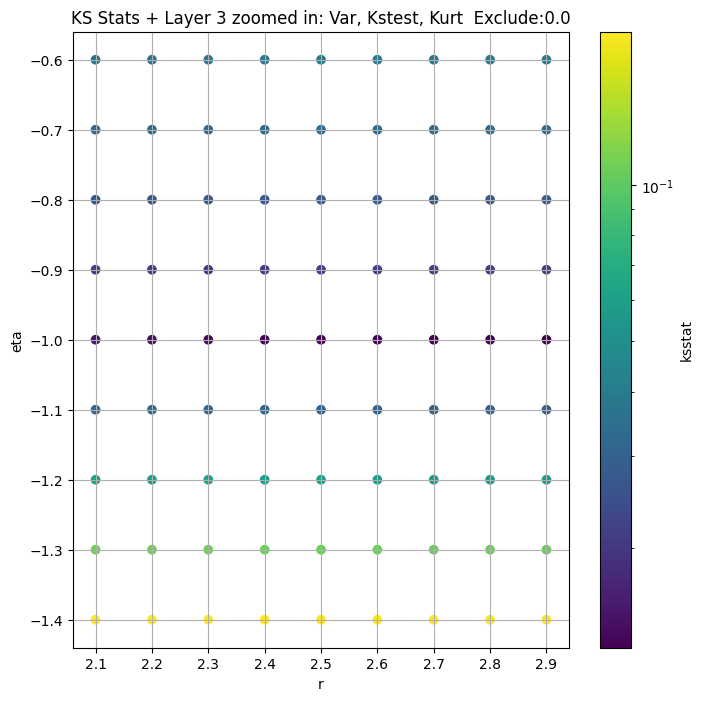

Layer 4


  0%|          | 0/400 [00:00<?, ?it/s]

Finding Minimum after computing 400 CDFs
layer 4, 200.0 + 100 = 300, ksstat: 0.029332574482058504, var: 42.49953079223633


  0%|          | 0/400 [00:00<?, ?it/s]

Finding Minimum after computing 400 CDFs
layer 4, 200.0 + 75 = 275, ksstat: 0.029339121454121986, var: 43.45182418823242


  0%|          | 0/400 [00:00<?, ?it/s]

Finding Minimum after computing 400 CDFs
layer 4, 200.0 + 50 = 250, ksstat: 0.029169897014188484, var: 44.46439743041992


  0%|          | 0/400 [00:00<?, ?it/s]

Finding Minimum after computing 400 CDFs
layer 4, 200.0 + 25 = 225, ksstat: 0.028437254246670873, var: 45.537742614746094


  0%|          | 0/400 [00:00<?, ?it/s]

Finding Minimum after computing 400 CDFs
layer 4, 200.0 + 0 = 200, ksstat: 0.028437231809218533, var: 46.67889404296875


  0%|          | 0/400 [00:00<?, ?it/s]

Finding Minimum after computing 400 CDFs
layer 4, 200.0 + -25 = 175, ksstat: 0.028437245810033596, var: 47.904754638671875


  0%|          | 0/400 [00:00<?, ?it/s]

Finding Minimum after computing 400 CDFs
layer 4, 200.0 + -50 = 150, ksstat: 0.02843717992723438, var: 49.20313262939453


  0%|          | 0/400 [00:00<?, ?it/s]

Finding Minimum after computing 400 CDFs
layer 4, 200.0 + -75 = 125, ksstat: 0.028437281590401042, var: 50.596168518066406


  0%|          | 0/400 [00:00<?, ?it/s]

Finding Minimum after computing 400 CDFs
layer 4, 200.0 + -100 = 100, ksstat: 0.02844514651337471, var: 52.12236785888672
Number of samples: 25664, Without approximation : 25664.0


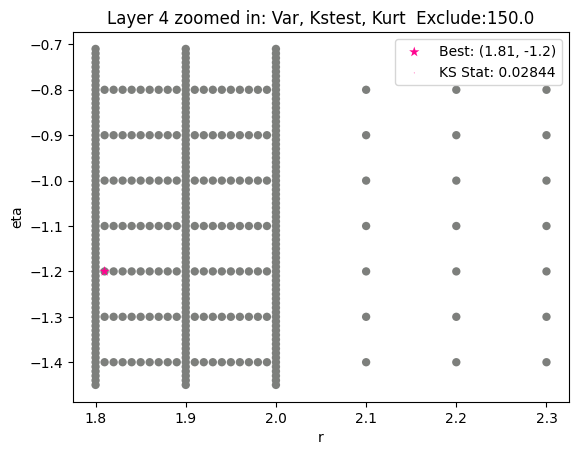

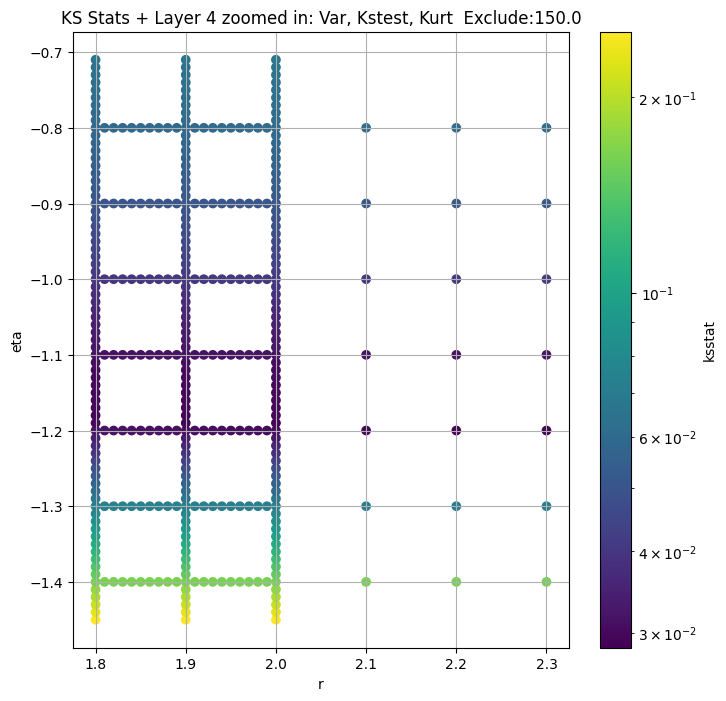

Layer 5


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.06243999999999977, var: 9.85930347442627


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.06243999999999977, var: 10.008465766906738


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.06243999999999977, var: 10.178216934204102


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.06243999999999977, var: 10.376113891601562


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.06243999999999977, var: 10.662790298461914
Number of samples: 100000, Without approximation : 102656.0


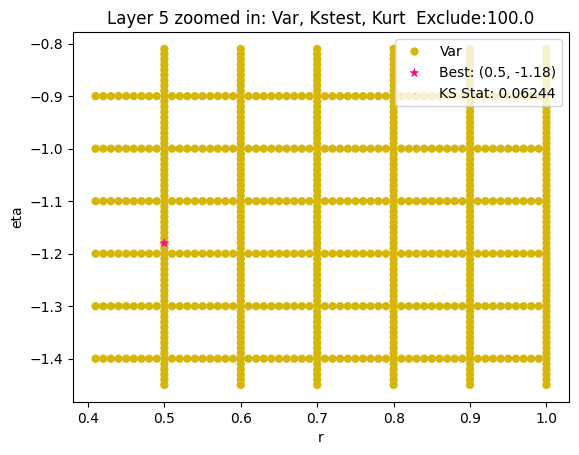

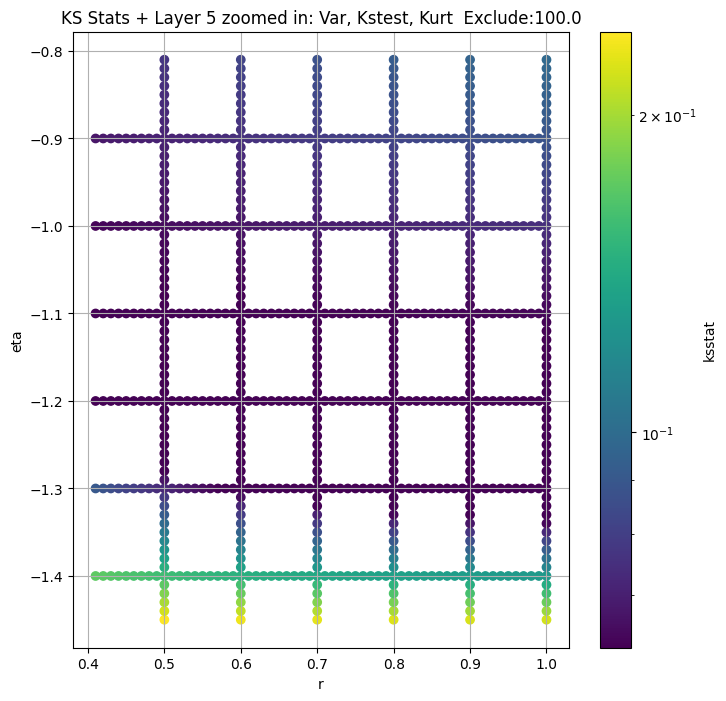

Layer 6


  0%|          | 0/158 [00:00<?, ?it/s]

Finding Minimum after computing 158 CDFs
layer 6, 0.0 + 100 = 100, ksstat: 0.10255999999999976, var: 1.6424254179000854


  0%|          | 0/158 [00:00<?, ?it/s]

Finding Minimum after computing 158 CDFs
layer 6, 0.0 + 75 = 75, ksstat: 0.10255999999999976, var: 1.673743486404419


  0%|          | 0/158 [00:00<?, ?it/s]

Finding Minimum after computing 158 CDFs
layer 6, 0.0 + 50 = 50, ksstat: 0.10255999999999976, var: 1.7088282108306885


  0%|          | 0/158 [00:00<?, ?it/s]

Finding Minimum after computing 158 CDFs
layer 6, 0.0 + 25 = 25, ksstat: 0.10255999999999976, var: 1.7506054639816284


  0%|          | 0/158 [00:00<?, ?it/s]

Finding Minimum after computing 158 CDFs
layer 6, 0.0 + 0 = 0, ksstat: 0.10255999999999976, var: 1.8123550415039062
Number of samples: 100000, Without approximation : 410624.0


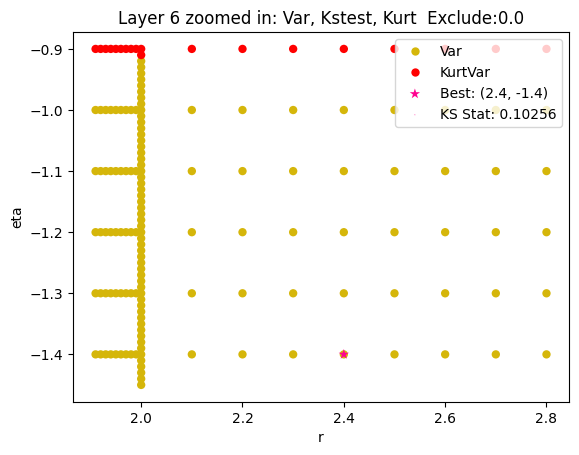

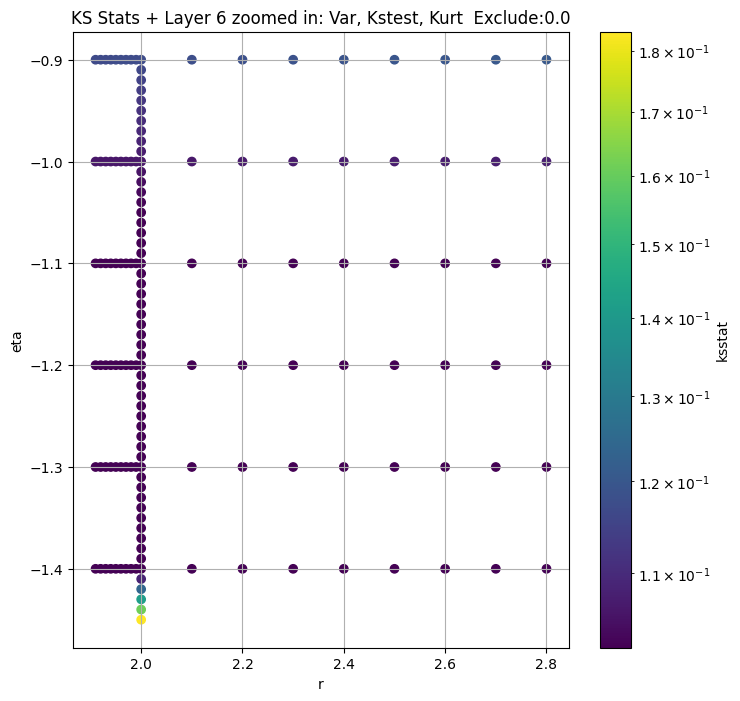

Layer 7


  0%|          | 0/158 [00:00<?, ?it/s]

Finding Minimum after computing 158 CDFs
layer 7, 0.0 + 100 = 100, ksstat: 0.14156999999999975, var: 0.3267766535282135


  0%|          | 0/158 [00:00<?, ?it/s]

Finding Minimum after computing 158 CDFs
layer 7, 0.0 + 75 = 75, ksstat: 0.14156999999999975, var: 0.334113746881485


  0%|          | 0/158 [00:00<?, ?it/s]

Finding Minimum after computing 158 CDFs
layer 7, 0.0 + 50 = 50, ksstat: 0.14156999999999975, var: 0.34240373969078064


  0%|          | 0/158 [00:00<?, ?it/s]

Finding Minimum after computing 158 CDFs
layer 7, 0.0 + 25 = 25, ksstat: 0.14156999999999975, var: 0.3523290157318115


  0%|          | 0/158 [00:00<?, ?it/s]

Finding Minimum after computing 158 CDFs
layer 7, 0.0 + 0 = 0, ksstat: 0.14156999999999975, var: 0.3675744831562042
Number of samples: 100000, Without approximation : 1642496.0


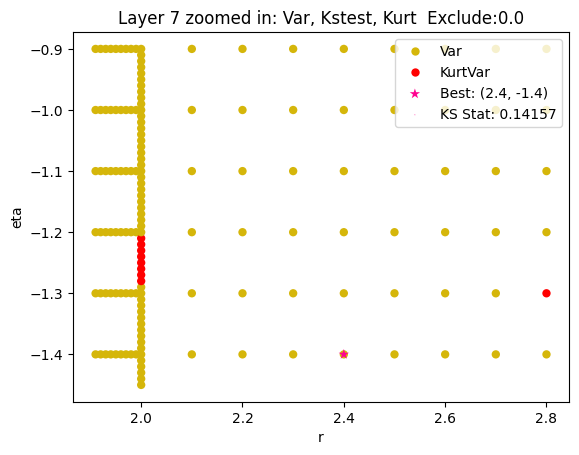

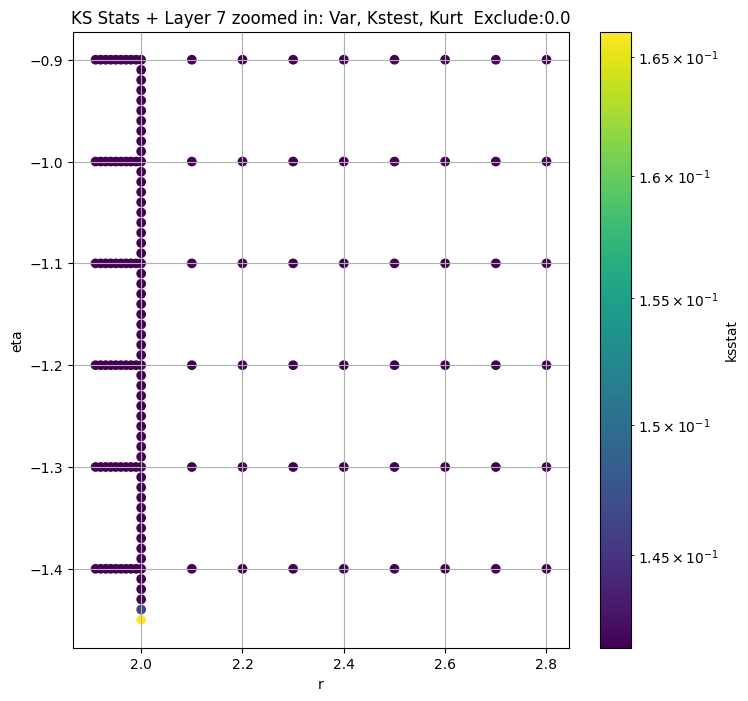

Layer 8


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.17545999999999978, var: 0.10448107868432999


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.17545999999999978, var: 0.10671380162239075


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.17545999999999978, var: 0.10927905142307281


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.17545999999999978, var: 0.11241155862808228


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.17545999999999978, var: 0.11764800548553467
Number of samples: 100000, Without approximation : 6569984.0


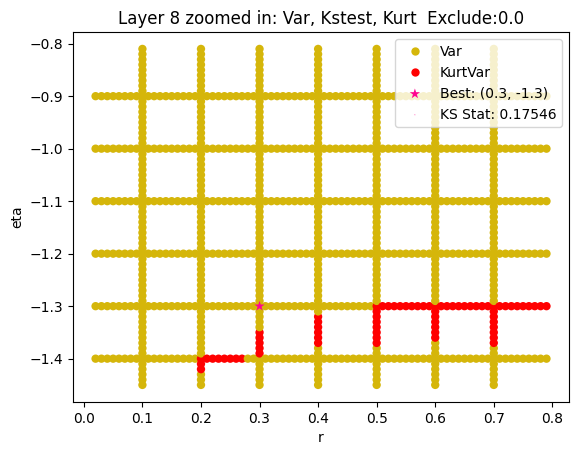

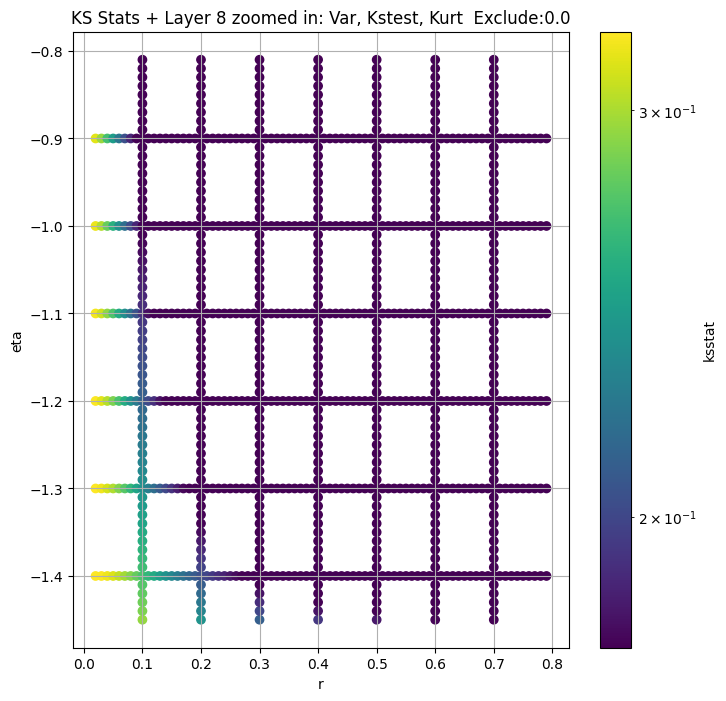

Layer 9


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 9, 0.0 + 100 = 100, ksstat: 0.20820999999999978, var: 0.05609099194407463


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 9, 0.0 + 75 = 75, ksstat: 0.20820999999999978, var: 0.05697648599743843


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 9, 0.0 + 50 = 50, ksstat: 0.20820999999999978, var: 0.058013081550598145


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 9, 0.0 + 25 = 25, ksstat: 0.20820999999999978, var: 0.05929768458008766


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 9, 0.0 + 0 = 0, ksstat: 0.20820999999999978, var: 0.061505239456892014
Number of samples: 100000, Without approximation : 26279936.0


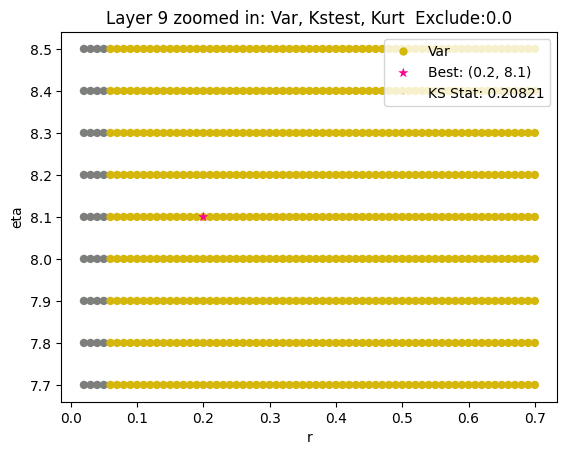

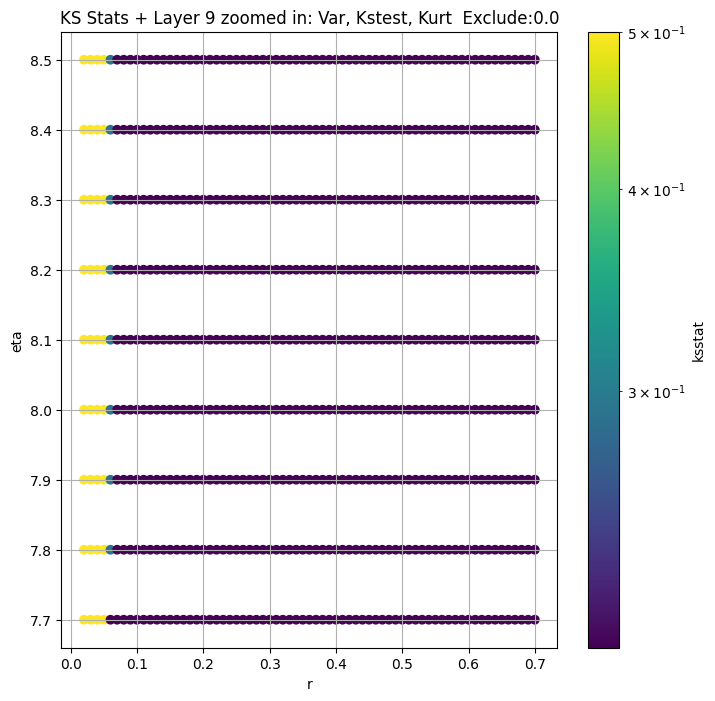

Not a fit


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff,n_pval_0.05
layer,,,,,,,,,,,,,,,,,,,,
2,1538.617600,1361.700400,1726.071300,1.384708,0.755833,2.144949,1604.0,0.012810,2.6,-0.6,3.165535e+03,0.0,1538.617554,0.033804,0.012805,3.00,-0.62,3.293317e+03,0.0,11556
3,319.928740,298.205600,342.533800,2.654936,2.018415,3.406429,6416.0,0.012830,2.5,-1.0,9.862681e+02,0.0,319.928740,0.016929,0.012830,2.50,-1.00,9.862681e+02,0.0,10827
4,61.059418,57.133404,65.097885,4.362754,3.728140,5.085071,25664.0,0.028437,2.3,-1.2,2.135705e+02,200.0,49.203133,0.008471,0.028437,1.81,-1.20,2.169027e+02,150.0,2406
5,10.662790,9.844688,11.527634,7.503035,6.107224,9.759243,102656.0,0.062440,0.9,-1.3,4.903539e+01,0.0,9.859303,0.004237,0.062440,0.50,-1.18,9.393391e+00,100.0,450
6,1.812355,1.650693,1.984610,10.935183,8.771862,14.155710,410624.0,0.102560,2.4,-1.4,2.200682e+01,0.0,1.812355,0.002119,0.102560,2.40,-1.40,2.200682e+01,0.0,168
7,0.367574,0.331668,0.407110,13.701681,10.461758,19.611970,1642496.0,0.141570,2.4,-1.4,4.463334e+00,0.0,0.367574,0.001060,0.141570,2.40,-1.40,4.463334e+00,0.0,94
8,0.117648,0.106599,0.130179,12.731473,8.530438,23.293043,6569984.0,0.175460,0.3,-1.3,2.655155e-02,0.0,0.117648,0.000530,0.175460,0.30,-1.30,2.655155e-02,0.0,55
9,0.061505,0.056850,0.066728,7.600587,4.638381,15.639812,26279936.0,0.208210,0.2,8.1,1.972111e-10,0.0,0.061505,0.000265,0.208210,0.20,8.10,1.972111e-10,0.0,-1


In [17]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

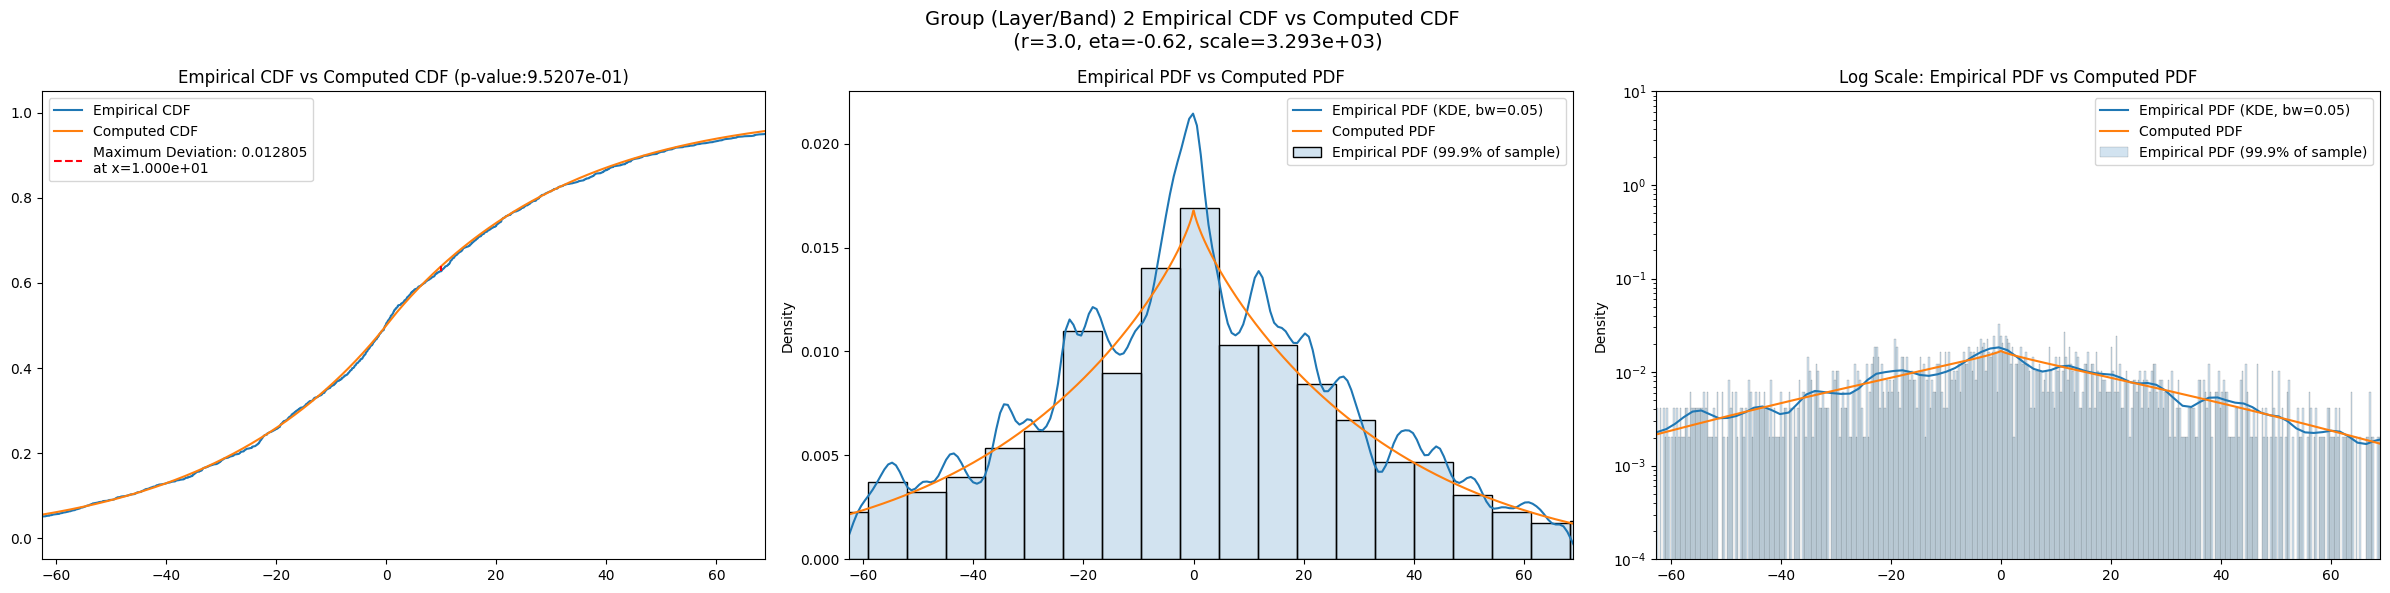

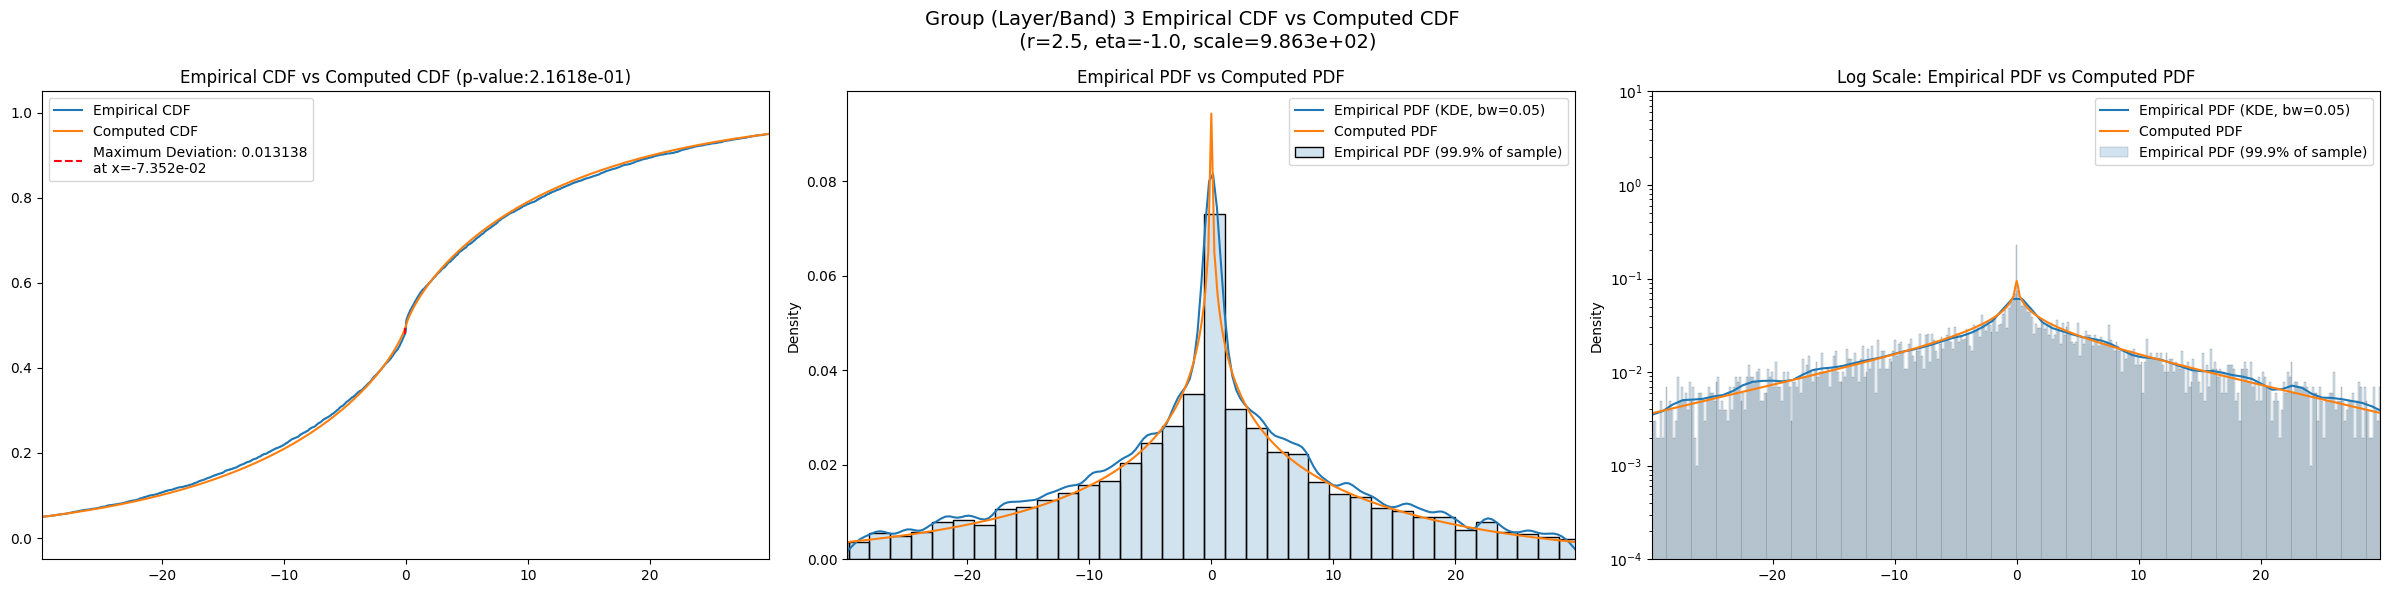

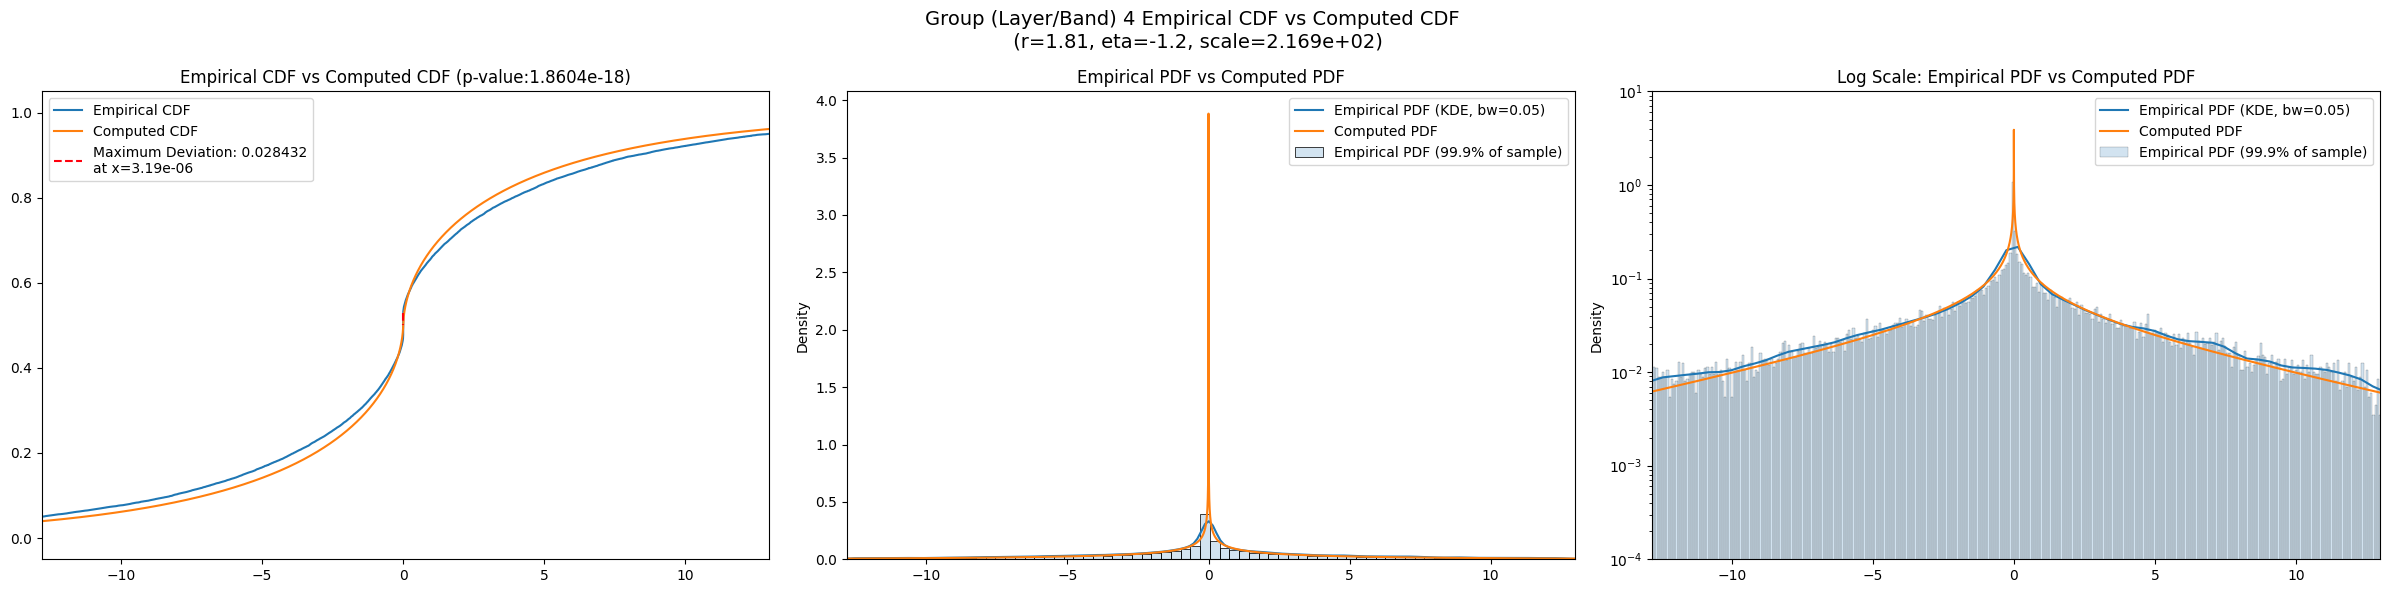

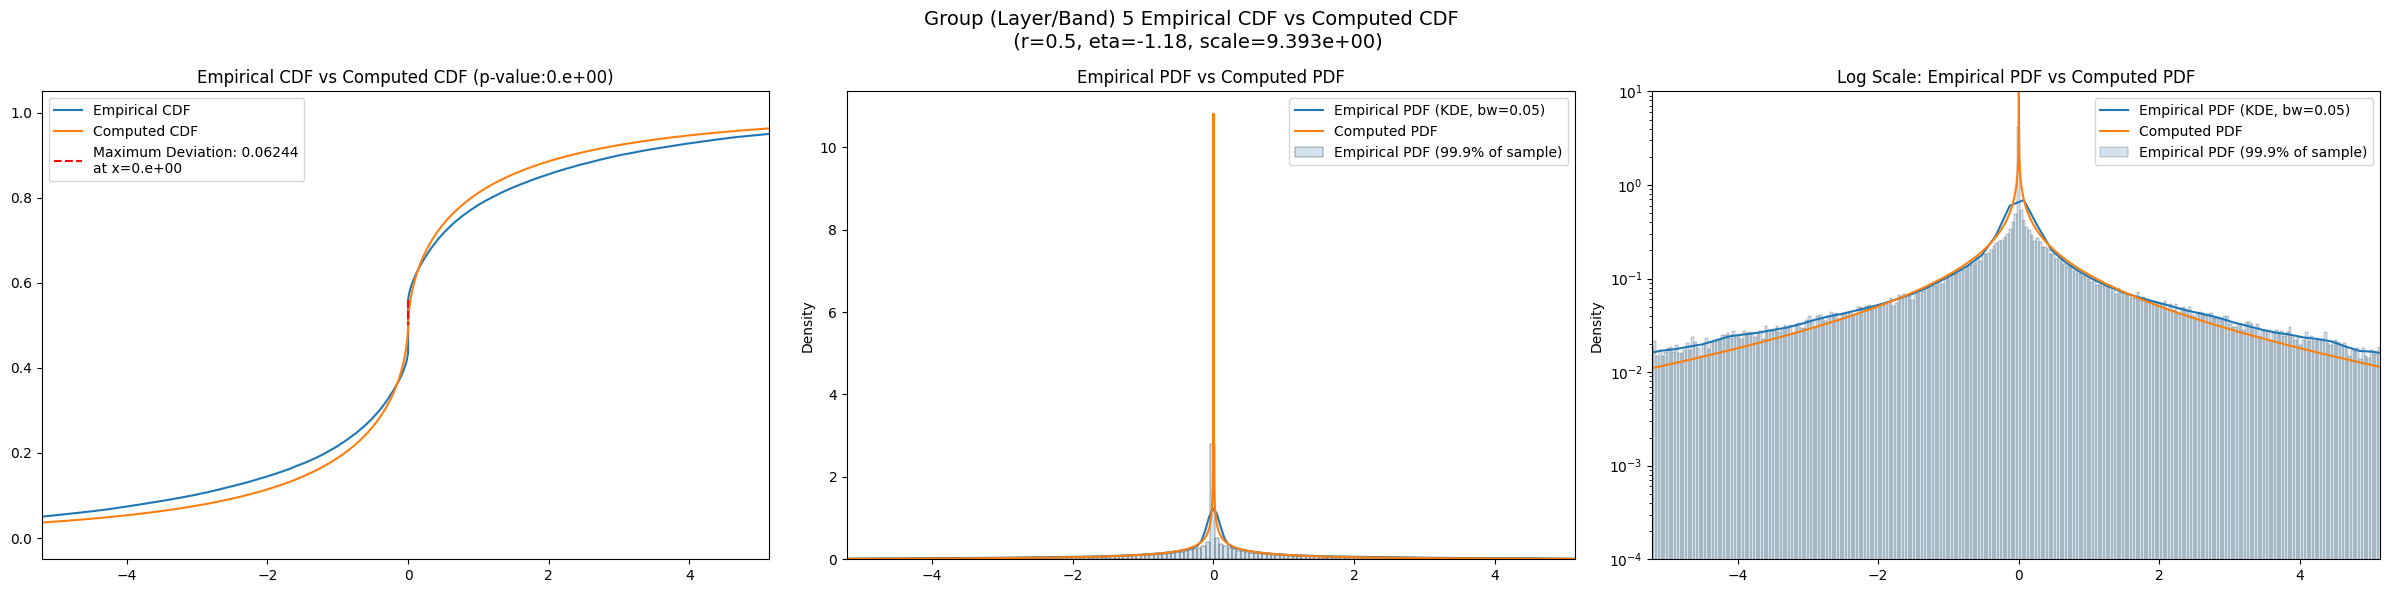

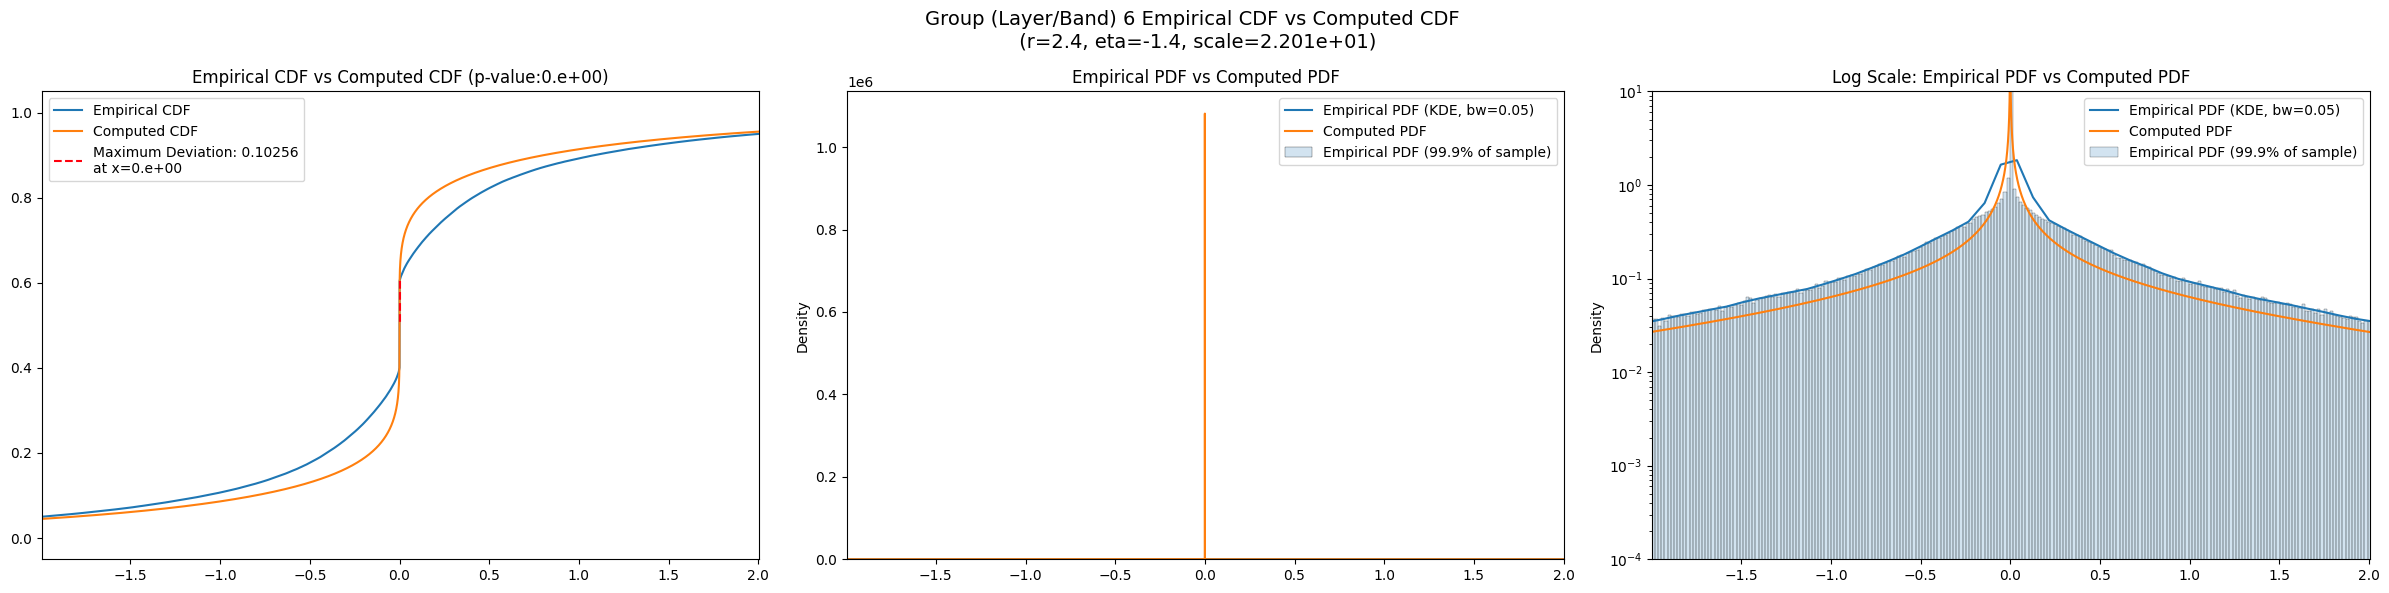

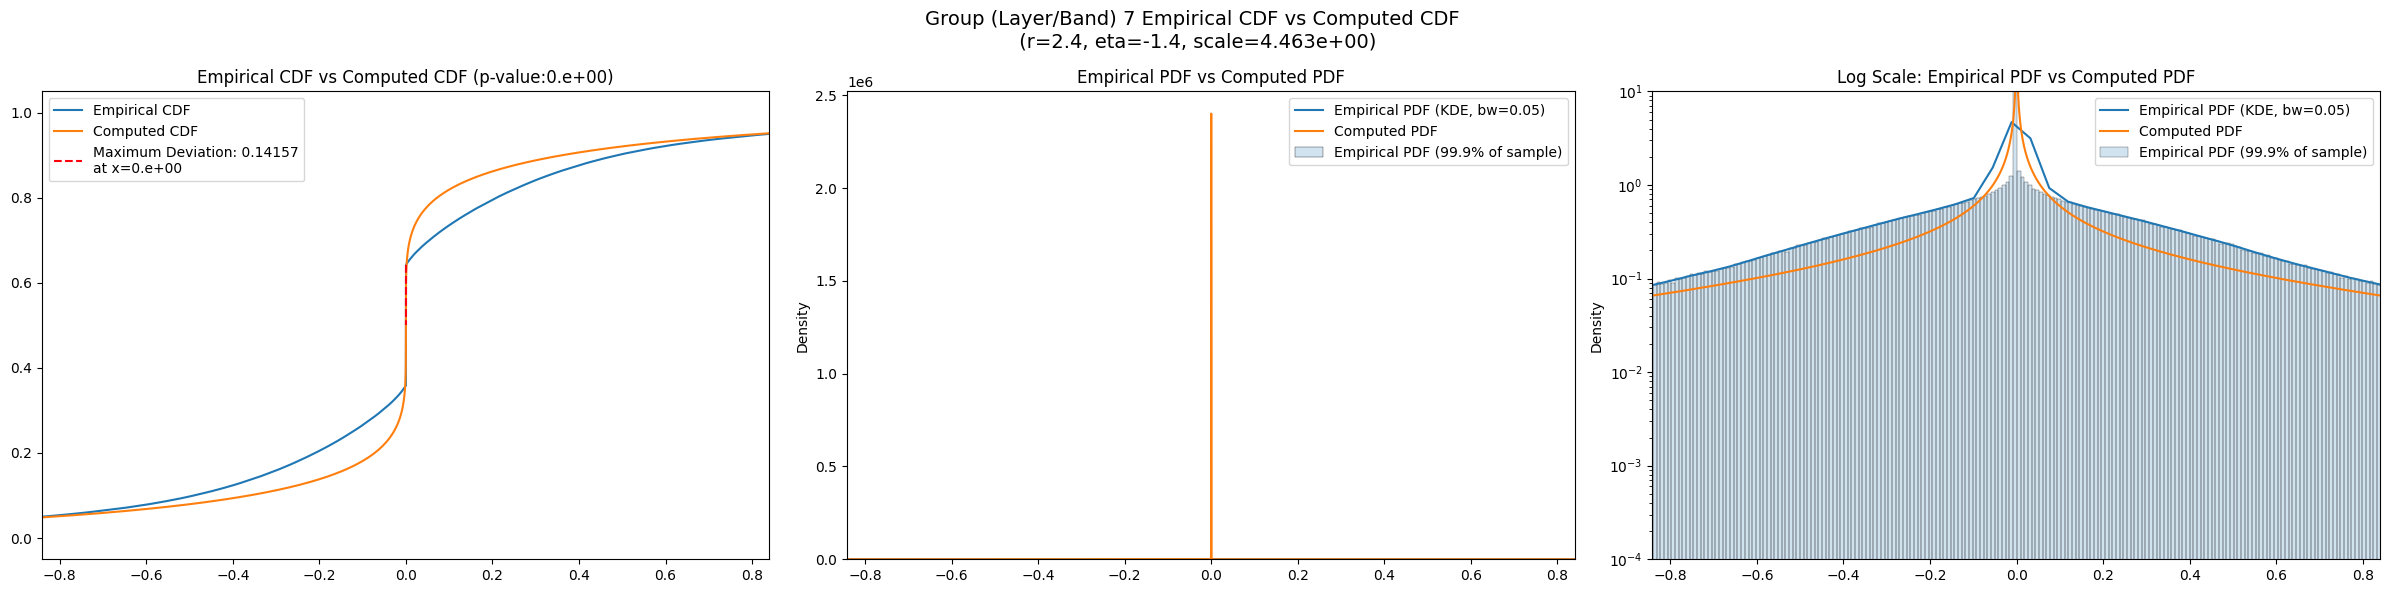

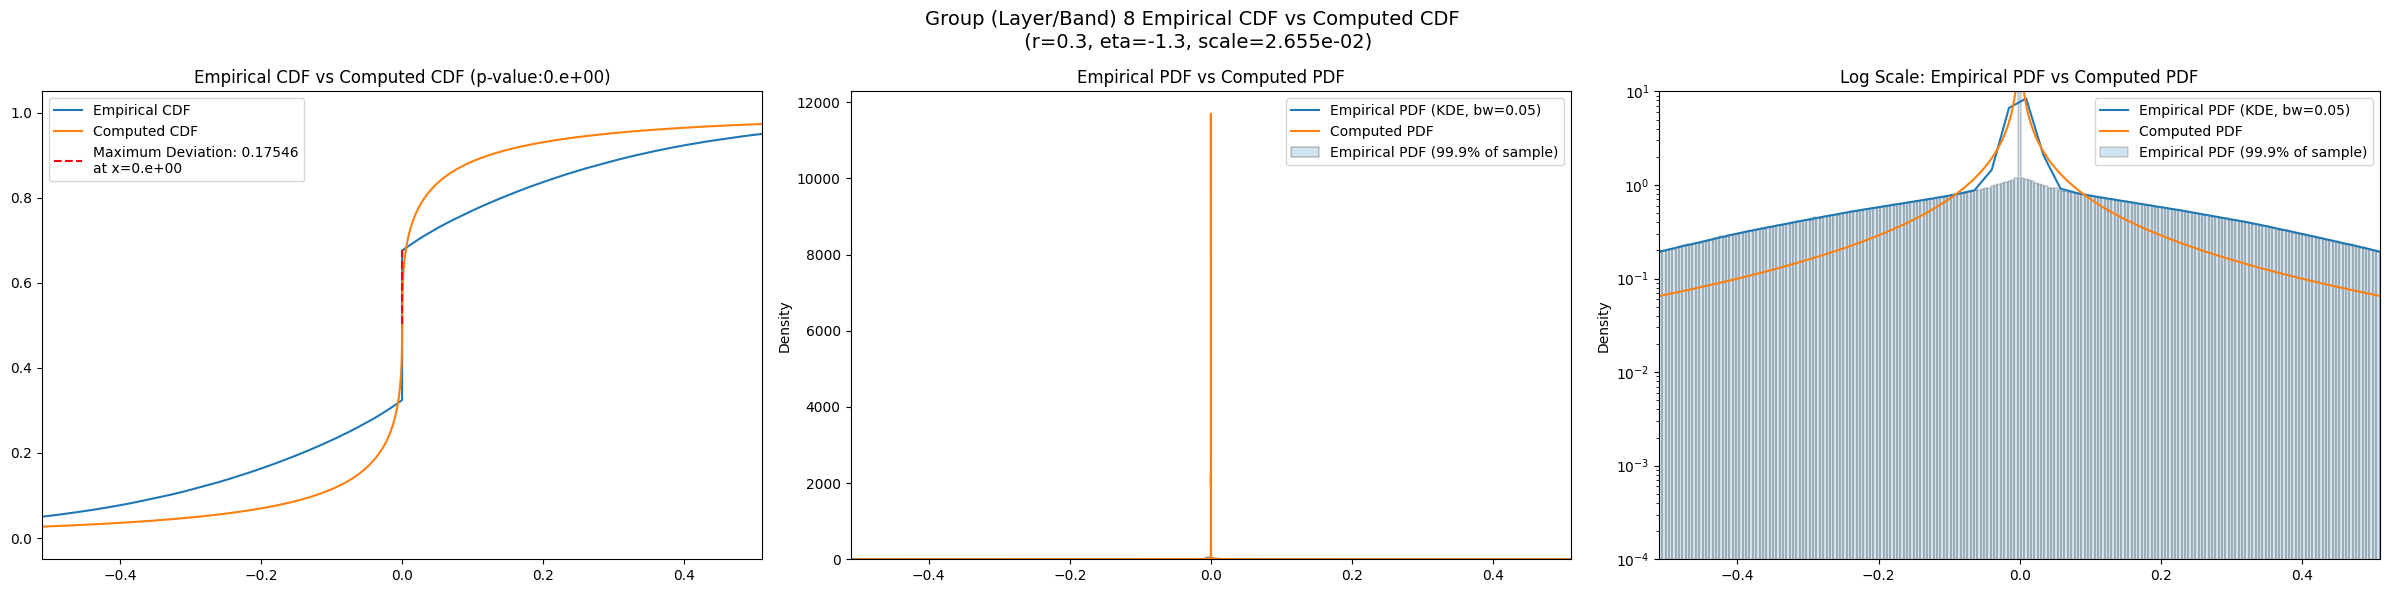

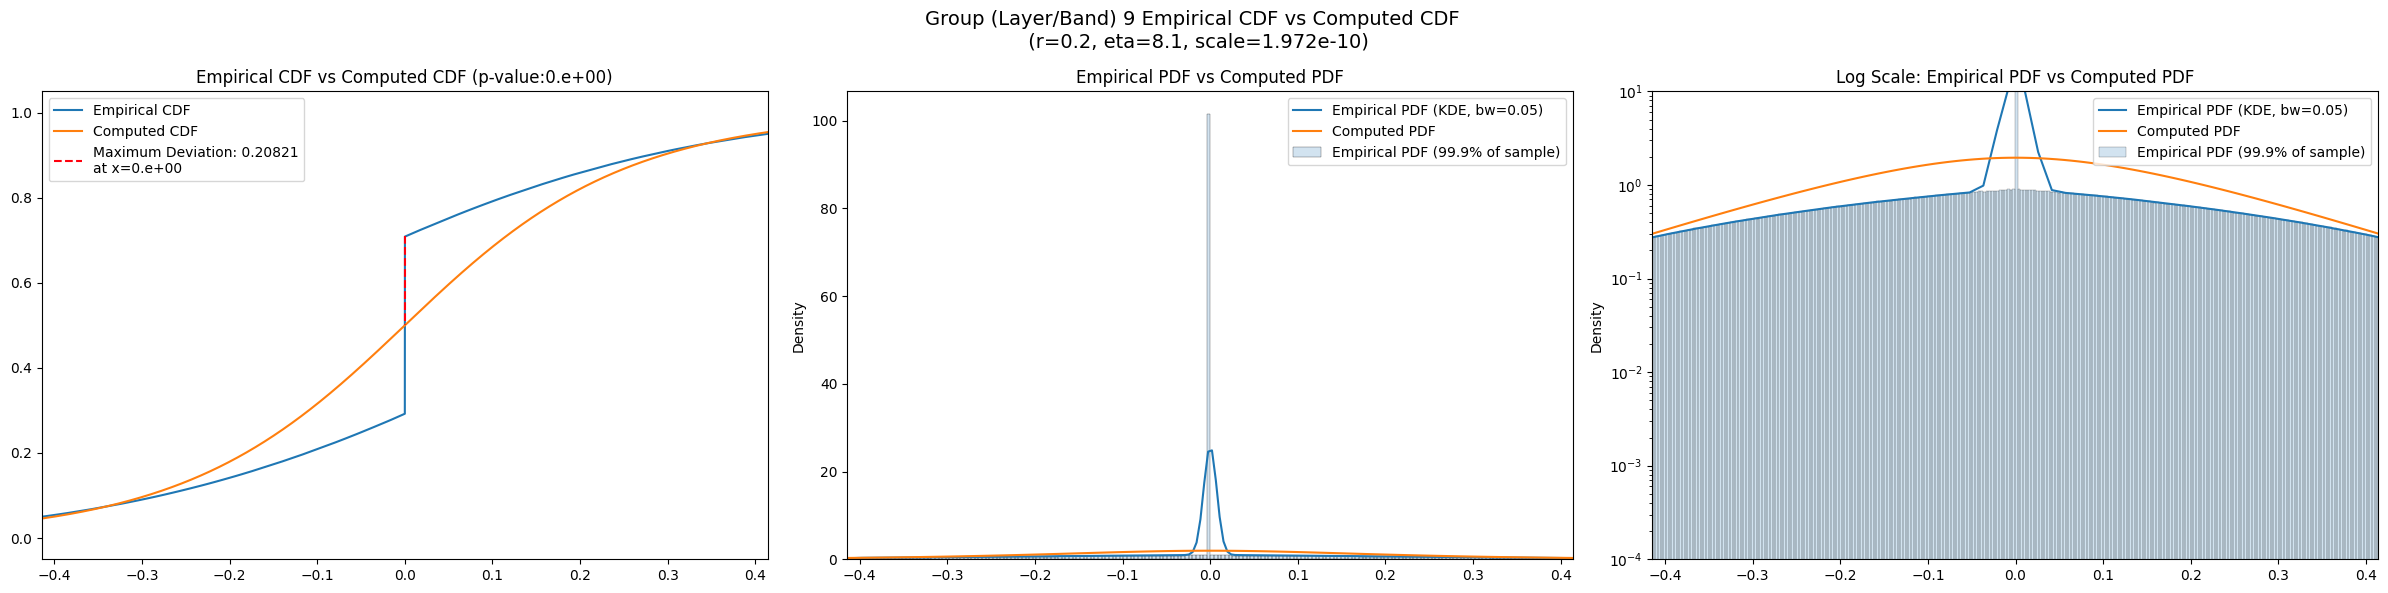

In [18]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [19]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [20]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,1538.617600,1361.700400,1726.071300,1.384708,0.755833,2.144949,1604.0,0.012810,2.6,-0.6,...,33.527600,0.032246,6.964260e-02,30.056100,0.015003,8.576610e-01,24.332200,0.020905,4.785000e-01,9.520749e-01
3,319.928740,298.205600,342.533800,2.654936,2.018415,3.406429,6416.0,0.012830,2.5,-1.0,...,13.285400,0.045929,3.361990e-12,11.089000,0.026768,1.993780e-04,9.300200,0.032218,3.204700e-06,2.394290e-01
4,61.059418,57.133404,65.097885,4.362754,3.728140,5.085071,25664.0,0.028437,2.3,-1.2,...,4.392350,0.071612,6.839860e-115,3.592060,0.051881,1.783080e-60,2.920780,0.055929,3.228360e-70,1.833148e-18
5,10.662790,9.844688,11.527634,7.503035,6.107224,9.759243,102656.0,0.062440,0.9,-1.3,...,1.346060,0.091576,0.000000e+00,1.055160,0.075656,0.000000e+00,0.824944,0.077727,0.000000e+00,0.000000e+00
6,1.812355,1.650693,1.984610,10.935183,8.771862,14.155710,410624.0,0.102560,2.4,-1.4,...,0.394559,0.107685,0.000000e+00,0.276697,0.102765,0.000000e+00,0.219419,0.103213,0.000000e+00,0.000000e+00
7,0.367574,0.331668,0.407110,13.701681,10.461758,19.611970,1642496.0,0.141570,2.4,-1.4,...,0.144082,0.141575,0.000000e+00,0.098700,0.141571,0.000000e+00,0.079150,0.141572,0.000000e+00,0.000000e+00
8,0.117648,0.106599,0.130179,12.731473,8.530438,23.293043,6569984.0,0.175460,0.3,-1.3,...,0.205307,0.175460,0.000000e+00,0.204799,0.175460,0.000000e+00,0.205308,0.175460,0.000000e+00,0.000000e+00
9,0.061505,0.056850,0.066728,7.600587,4.638381,15.639812,26279936.0,0.208210,0.2,8.1,...,0.332194,0.208210,0.000000e+00,0.332193,0.208210,0.000000e+00,0.205309,0.208210,0.000000e+00,0.000000e+00


## Results

In [21]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [22]:
master_df.filter(regex="kstest_stat.*")

,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_best,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t
layer,,,,,,
2,0.012810,0.033804,0.012805,0.032246,0.015003,0.020905
3,0.012830,0.016929,0.012830,0.045929,0.026768,0.032218
4,0.028437,0.008471,0.028437,0.071612,0.051881,0.055929
5,0.062440,0.004237,0.062440,0.091576,0.075656,0.077727
6,0.102560,0.002119,0.102560,0.107685,0.102765,0.103213
7,0.141570,0.001060,0.141570,0.141575,0.141571,0.141572
8,0.175460,0.000530,0.175460,0.175460,0.175460,0.175460
9,0.208210,0.000265,0.208210,0.208210,0.208210,0.208210


In [23]:
master_df.filter(regex="best.*")

,best_augmented_var,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff
layer,,,,,,
2,1538.617554,0.012805,3.00,-0.62,3.293317e+03,0.0
3,319.928740,0.012830,2.50,-1.00,9.862681e+02,0.0
4,49.203133,0.028437,1.81,-1.20,2.169027e+02,150.0
5,9.859303,0.062440,0.50,-1.18,9.393391e+00,100.0
6,1.812355,0.102560,2.40,-1.40,2.200682e+01,0.0
7,0.367574,0.141570,2.40,-1.40,4.463334e+00,0.0
8,0.117648,0.175460,0.30,-1.30,2.655155e-02,0.0
9,0.061505,0.208210,0.20,8.10,1.972111e-10,0.0
